## Aplicando ElasticNet: Seleção de Atributos com Regularização

O `ElasticNet`, da biblioteca `sklearn.linear_model`, é um modelo de regressão linear com regularização combinada das penalizações **L1 (Lasso)** e **L2 (Ridge)**. Ele é útil especialmente quando lidamos com datasets que possuem **muitas variáveis** ou **colinearidade entre atributos**.

###  O que ele faz?

O `ElasticNet` tenta ajustar um modelo linear aos dados, mas ao mesmo tempo **penaliza a complexidade do modelo**. A penalização L1 incentiva o modelo a reduzir coeficientes de atributos menos relevantes para zero, o que funciona como uma forma de **seleção automática de features**. Já a penalização L2 ajuda a manter a estabilidade dos coeficientes e controlar o overfitting.

O modelo é controlado por dois hiperparâmetros principais:
- `alpha`: controla a força total da regularização.
- `l1_ratio`: define o equilíbrio entre L1 (sparse) e L2 (shrinkage).  
  - `l1_ratio = 0`: equivalente a Ridge
  - `l1_ratio = 1`: equivalente a Lasso
  - `0 < l1_ratio < 1`: combinação dos dois

###  Aplicação no Projeto

Neste projeto, utilizaremos o `ElasticNet` após a aplicação de `PolynomialFeatures` para reduzir a quantidade de atributos gerados. O objetivo é **manter apenas as features que contribuem efetivamente para a performance do modelo**, reduzindo a dimensionalidade e melhorando a interpretabilidade.

Esse passo é especialmente importante após a expansão polinomial, pois ajuda a **controlar a explosão de atributos** e evita o uso de variáveis desnecessárias, promovendo um modelo mais enxuto e eficiente.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.26,37.84,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294118,2.026891,0.260274
3,-122.26,37.85,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.26,37.84,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343675,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 17564 non-null  float64
 1   latitude                  17564 non-null  float64
 2   housing_median_age        17564 non-null  int8   
 3   total_rooms               17564 non-null  int16  
 4   total_bedrooms            17564 non-null  int16  
 5   population                17564 non-null  int16  
 6   households                17564 non-null  int16  
 7   median_income             17564 non-null  float64
 8   median_house_value        17564 non-null  int32  
 9   ocean_proximity           17564 non-null  object 
 10  median_income_cat         17564 non-null  int64  
 11  rooms_per_household       17564 non-null  float64
 12  population_per_household  17564 non-null  float64
 13  bedrooms_per_room         17564 non-null  float64
dtypes: flo

In [4]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

In [5]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])

preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler),
    ],
)

In [7]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [8]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.26,37.84,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294118,2.026891,0.260274
3,-122.26,37.85,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.26,37.84,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343675,2.362768,0.203216


In [9]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [10]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha": [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0],
    "regressor__reg__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9],
}

In [11]:
grid_search = grid_search_cv_regressor(
    regressor=ElasticNet(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [12]:
grid_search.fit(X, y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


C:\ProgramData\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.540e+02, tolerance: 1.782e+00
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

#### Melhores Parâmetros Encontrados:

- **Grau polinomial:** 3 (captura relações não-lineares)
- **Alpha:** 0.01 (regularização suave)
- **L1 Ratio:** 0.1 (10% Lasso + 90% Ridge)

In [13]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 0.01,
 'regressor__reg__l1_ratio': 0.1}

In [14]:
grid_search.best_score_

np.float64(-51284.33202176415)

In [15]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
one_hot__ocean_proximity_INLAND,-0.603952
robust_scaler_poly__longitude,-0.383335
robust_scaler_poly__population_per_household,-0.343299
robust_scaler_poly__latitude,-0.212270
robust_scaler_poly__latitude^2,-0.195826
...,...
ordinal_encoder__median_income_cat,0.092968
robust_scaler_poly__housing_median_age longitude^2,0.107035
robust_scaler_poly__bedrooms_per_room,0.130318
robust_scaler_poly__housing_median_age median_income,0.180955


#### Coeficientes 

- **Problema:** crescimento exponencial de coeficientes
- **vantagem:** coeficientes appresentam uma menor faixa de valores

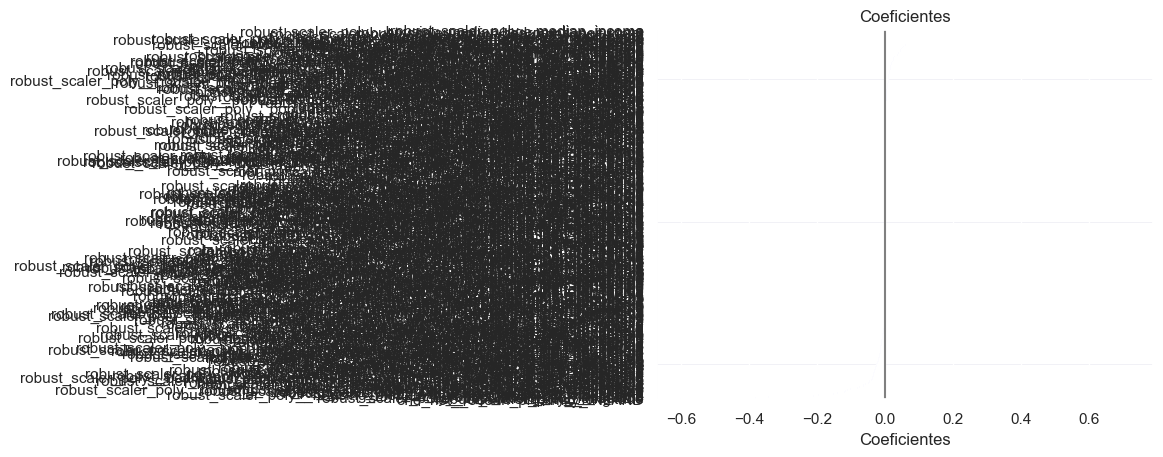

In [16]:
plot_coeficientes(coefs)

In [17]:
# Verificando os coeficientes que foram zerados 
coefs[coefs["coeficiente"] == 0]

,coeficiente
robust_scaler_poly__bedrooms_per_room housing_median_age rooms_per_household,-0.0
robust_scaler_poly__population_per_household total_bedrooms^2,0.0
robust_scaler_poly__population_per_household rooms_per_household total_bedrooms,-0.0
robust_scaler_poly__median_income rooms_per_household total_bedrooms,-0.0
robust_scaler_poly__population_per_household^2 total_bedrooms,0.0
...,...
robust_scaler_poly__population total_bedrooms^2,-0.0
robust_scaler_poly__total_bedrooms total_rooms^2,0.0
robust_scaler_poly__total_rooms^3,0.0
robust_scaler_poly__total_bedrooms^2 total_rooms,-0.0


In [25]:
# Verificando os coeficientes que coloboram pouco com o modelo 
coefs[coefs["coeficiente"].between(-0.1, 0.1) & (coefs["coeficiente"] != 0)]

,coeficiente
robust_scaler_poly__bedrooms_per_room^2 median_income,-0.082218
robust_scaler_poly__bedrooms_per_room^2 latitude,-0.076196
robust_scaler_poly__median_income^2,-0.066086
robust_scaler_poly__housing_median_age latitude,-0.065252
robust_scaler_poly__median_income population_per_household,-0.059642
...,...
robust_scaler_poly__housing_median_age latitude population_per_household,0.075894
robust_scaler_poly__housing_median_age population_per_household^2,0.084679
robust_scaler_poly__housing_median_age,0.088610
robust_scaler_poly__median_income total_bedrooms,0.092330


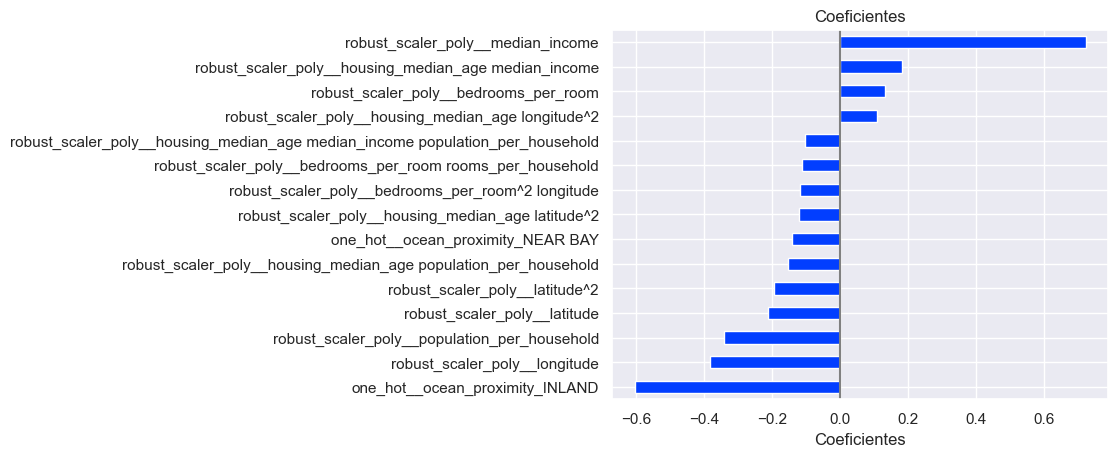

In [19]:
plot_coeficientes(coefs[~coefs["coeficiente"].between(-0.1, 0.1)])

In [20]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    "ElasticNet_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

C:\ProgramData\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.266e+01, tolerance: 1.415e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.647e+01, tolerance: 1.442e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.016004,0.014998,-0.000081,-77516.042766,-96239.705692,0.031002
1,DummyRegressor,0.014002,0.011996,-0.000146,-75787.787194,-95217.629397,0.025998
2,DummyRegressor,0.008994,0.013004,-0.001737,-76753.598961,-96253.253947,0.021998
3,DummyRegressor,0.009997,0.014994,-0.000101,-76837.804811,-95983.885799,0.024991
4,DummyRegressor,0.009006,0.011998,-0.000114,-76617.245449,-96182.764729,0.021003
5,LinearRegression,0.143009,0.032997,0.682162,-39855.691222,-54254.958862,0.176006
6,LinearRegression,0.083002,0.032997,0.66999,-40272.5658,-54695.230987,0.115999
7,LinearRegression,0.073,0.03,0.649247,-42178.059695,-56955.987903,0.103001
8,LinearRegression,0.064006,0.029994,0.669873,-40806.492334,-55146.319086,0.094001
9,LinearRegression,0.077998,0.031,0.669023,-40788.497206,-55331.350878,0.108997


In [21]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.0116,0.013398,-0.000436,-76702.495836,-95975.447913,0.024998
ElasticNet_grid_search,57.310588,0.194647,0.71388,-36003.315112,-51308.771031,57.505235
LinearRegression,0.088203,0.031398,0.668059,-40780.261251,-55276.769543,0.119601
LinearRegression_target,0.1506,0.050601,0.678109,-38675.951272,-54429.586312,0.201201


In [22]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.0116,0.013398,-0.000436,-76702.495836,-95975.447913,0.024998
LinearRegression,0.088203,0.031398,0.668059,-40780.261251,-55276.769543,0.119601
LinearRegression_target,0.1506,0.050601,0.678109,-38675.951272,-54429.586312,0.201201
ElasticNet_grid_search,57.310588,0.194647,0.71388,-36003.315112,-51308.771031,57.505235


### Principais Insights

1. **Ganhos de Performance:**

    - **+3.6% no R²** (0.678 → 0.714)

    - **Redução de 6.9% no MAE** (38,674 → 36,004 USD)

    - **Redução de 5.7% no RMSE** (54,418 → 51,296 USD)

2. **Custo Computacional:**

    - 80x mais lento no treino (devido à busca combinatória)

    - 2.3x mais lento em predição (fator crítico para produção)

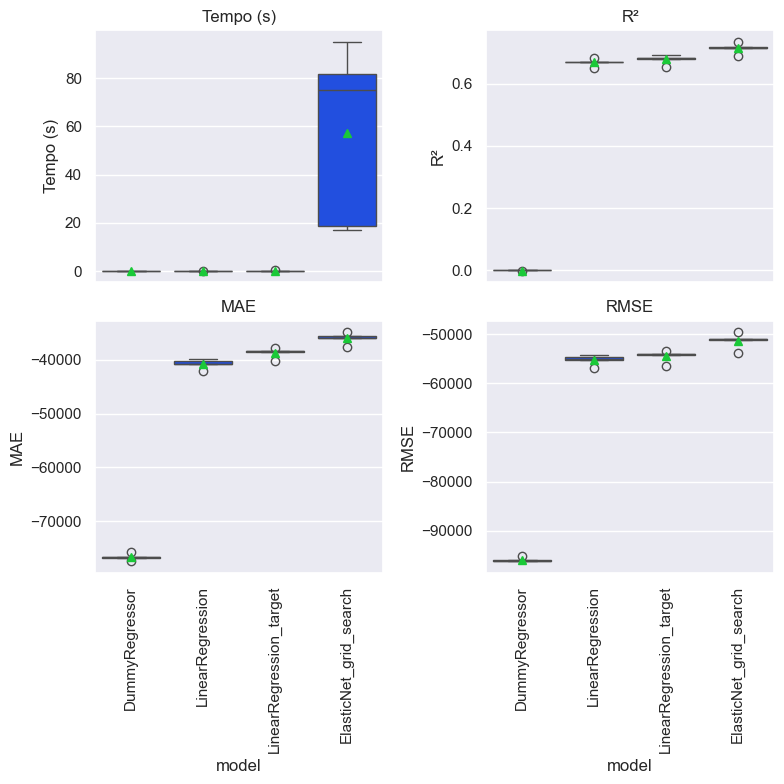

In [23]:
plot_comparar_metricas_modelos(df_resultados)

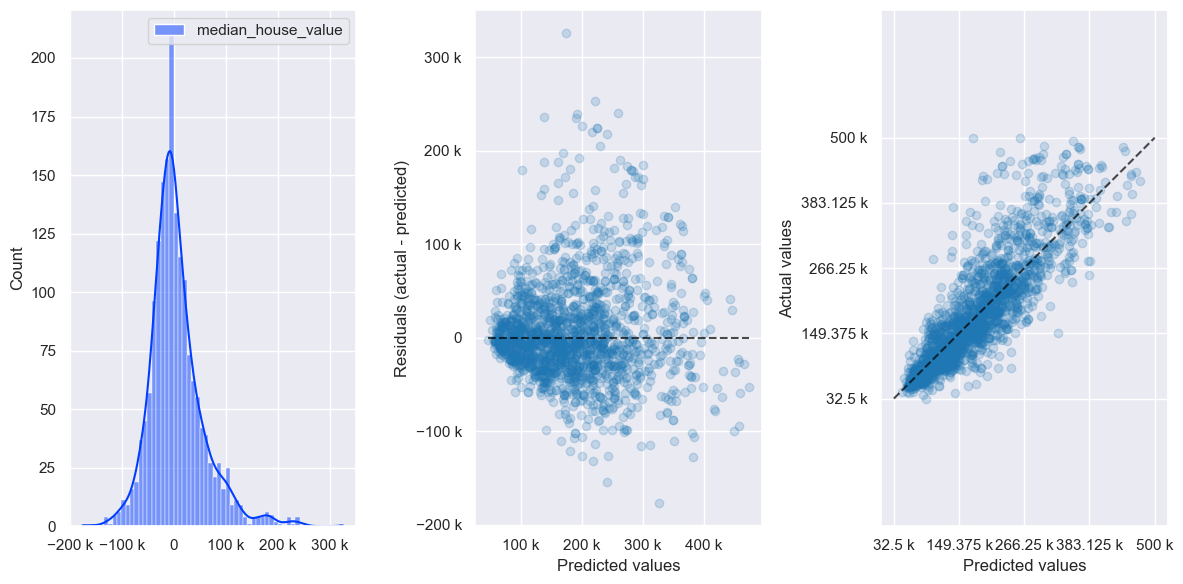

In [24]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

## Próxima Etapa: Transição para Ridge Regression Puro

###  **Objetivos da Análise com Ridge**

1. **Validação da Hipótese do ElasticNet**  
   - O melhor modelo ElasticNet encontrou `l1_ratio=0.1` (90% Ridge + 10% Lasso)  
   - **Hipótese**: O Ridge puro pode oferecer resultados similares com menor custo computacional
 